This is a notebook doing the entire pipeline of the preprocessing 

In [1]:
# Import necessary libraries
import numpy as np
import json
import glob
import os

# Define the candidate's name
candidate = "pilot_van_riet"

# Define paths to the directories and files
data_directory = rf'C:\Users\wille\AppData\Roaming\Godot\app_userdata\{candidate}'
tooth_data_path = r'C:\Users\wille\OneDrive\Documenten\Tu Delft\Msc, Robotics\Afstuderen\AMC\Coding\thesis\descriptive_tooth_extraction\src\geometry\teeth_data.json'

# Load tooth data
with open(tooth_data_path, 'r') as file:
    tooth_data = json.load(file)


output_data_list = []
# Process each sensor data file that starts with 'extraction_data'
for sensor_data_path in glob.glob(os.path.join(data_directory, 'extraction_data*.json')):
    with open(sensor_data_path, 'r') as file:
        sensor_data = json.load(file)

    # Initialize lists to store translated forces and torques
    translated_forces = []
    translated_torques = []


    # Extract relevant data from sensor_data
    quadrant = sensor_data["quadrant"]
    tooth = sensor_data["tooth"]
    person_type = sensor_data["person_type"]
    element_fractured = sensor_data["element_fractured"]
    start_timestamp = sensor_data["start_timestamp"]
    end_timestamp = sensor_data["end_timestamp"]
    epoxy_failed = sensor_data["epoxy_failed"]
    forceps_slipped = sensor_data["forceps_slipped"]
    format_version = sensor_data["format_version"]
    jaw_type = sensor_data["jaw_type"]
    nonrepresentative = sensor_data["nonrepresentative"]
    person_type = sensor_data["person_type"]
    post_extraction_notes = sensor_data["post_extraction_notes"]

    # Form the key for accessing tooth data
    quadrant_key = f"Quadrant {quadrant}"
    tooth_key = str(tooth)

    # Extract relevant tooth data
    coordinates = np.array([tooth_data[quadrant_key][tooth_key]["coordinates"]["x"],
                            tooth_data[quadrant_key][tooth_key]["coordinates"]["y"],
                            tooth_data[quadrant_key][tooth_key]["coordinates"]["z"]])

    rotation = np.array(tooth_data[quadrant_key][tooth_key]["rotation"])

    # Extract forces and torques
    forces = np.array([sensor_data["raw_forces_x"],
                       sensor_data["raw_forces_y"],
                       sensor_data["raw_forces_z"]])

    torques = np.array([sensor_data["raw_torques_x"],
                        sensor_data["raw_torques_y"],
                        sensor_data["raw_torques_z"]])

    # Compute translated forces and torques
    for i in range(len(forces[0])):
        force_vector = forces[:, i]
        torque_vector = torques[:, i]

        # Translate forces (just rotation)
        # Translate forces (just rotation)
        translated_force = rotation.dot(force_vector)
        if quadrant in [1, 4]:
            translated_force[1] *= -1  # Flip the y-component
        translated_forces.append(translated_force.tolist())

        # Translate torques (rotation and translation correction)
        translated_torque = rotation.dot(torque_vector) - np.cross(coordinates, translated_force)
        if quadrant in [1, 4]:
            translated_torque[1] *= -1  # Flip the y-component
        translated_torques.append(translated_torque.tolist())

    # Prepare the output data
    output_data = {
        "quadrant": quadrant,
        "tooth": tooth,
        "person_type" : person_type,
        "element_fractured": element_fractured,
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
        "epoxy_failed": epoxy_failed,
        "forceps_slipped": forceps_slipped,
        "format_version": format_version,
        "jaw_type": jaw_type,
        "nonrepresentative": nonrepresentative,
        "person_type": person_type,
        "post_extraction_notes": post_extraction_notes,
        "translated_forces_x": [f[0] for f in translated_forces],
        "translated_forces_y": [f[1] for f in translated_forces],
        "translated_forces_z": [f[2] for f in translated_forces],
        "translated_torques_x": [t[0] for t in translated_torques],
        "translated_torques_y": [t[1] for t in translated_torques],
        "translated_torques_z": [t[2] for t in translated_torques]
    }

    # Display the output data
    output_data_list.append(output_data)

print(len(output_data_list))


64


3
4
Number of data points: 17323
Recording duration: 17.488999843597412 seconds
Sampling frequency: 990.5083283731526 Hz


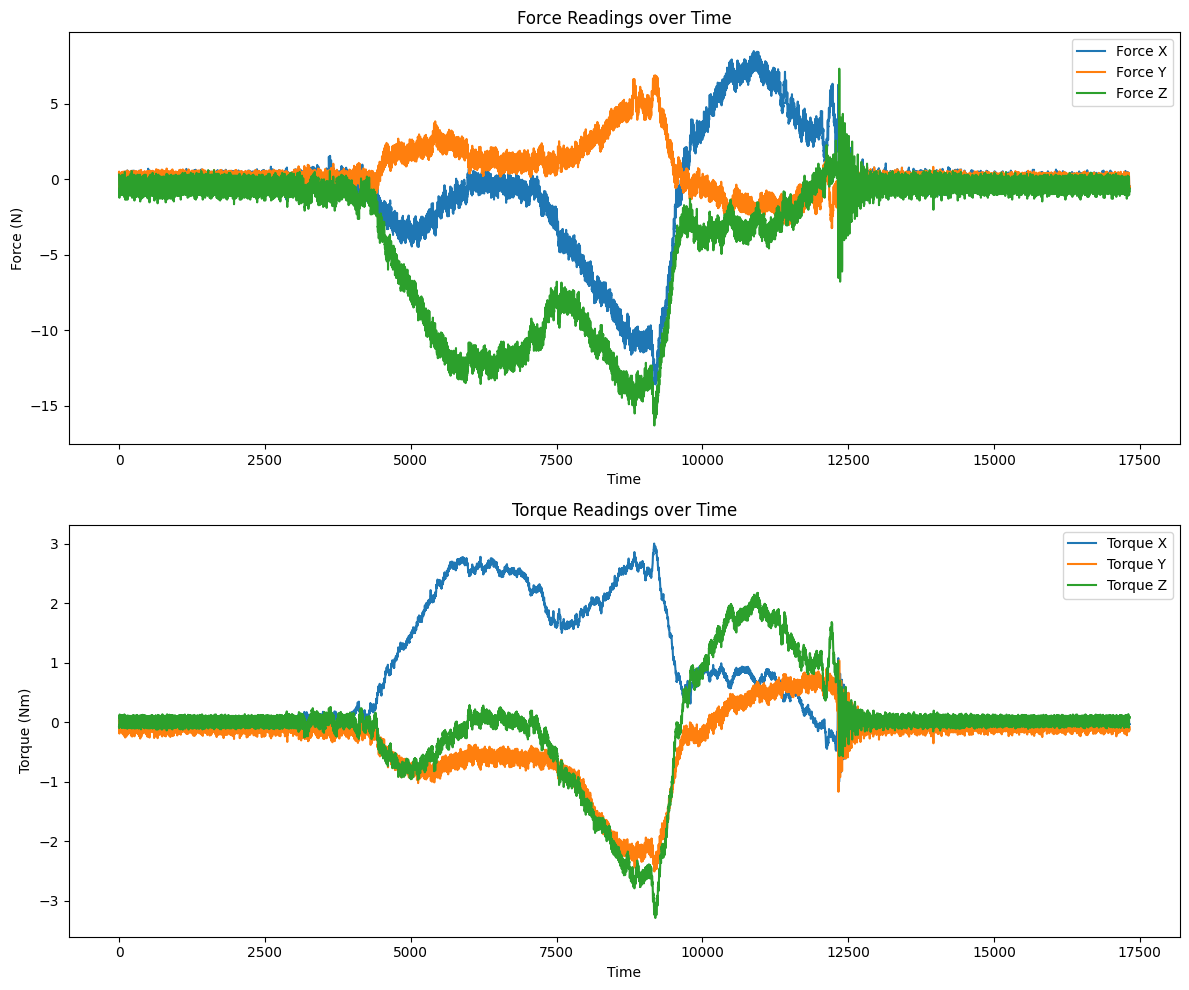

In [2]:
import matplotlib.pyplot as plt

def plot_sensor_data_from_json(data):
    def prepare_data(data):
        print(f"Number of data points: {len(data['translated_forces_x'])}")
        duration = data['end_timestamp'] - data['start_timestamp']
        frequency = len(data['translated_forces_x']) / duration
        print(f"Recording duration: {duration} seconds")
        print(f"Sampling frequency: {frequency} Hz")

        raw_forces = [data['translated_forces_x'], data['translated_forces_y'], data['translated_forces_z']]
        raw_torques = [data['translated_torques_x'], data['translated_torques_y'], data['translated_torques_z']]
        return np.array(raw_forces + raw_torques).T

    # Load sensor data
    sensor_data = prepare_data(data)

    # Plotting the data
    force_labels = ['Force X', 'Force Y', 'Force Z']
    torque_labels = ['Torque X', 'Torque Y', 'Torque Z']

    # Create a new figure for each plot
    plt.figure(figsize=(12, 10))

    # Time-series Plot for Forces
    plt.subplot(2, 1, 1)
    for i in range(3):
        plt.plot(sensor_data[:, i], label=force_labels[i])
    plt.title('Force Readings over Time')
    plt.xlabel('Time')
    plt.ylabel('Force (N)')
    plt.legend()

    # Time-series Plot for Torques
    plt.subplot(2, 1, 2)
    for i in range(3, 6):
        plt.plot(sensor_data[:, i], label=torque_labels[i - 3])
    plt.title('Torque Readings over Time')
    plt.xlabel('Time')
    plt.ylabel('Torque (Nm)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example use
run = 4

print(output_data_list[run]["quadrant"])
print(output_data_list[run]["tooth"])
plot_sensor_data_from_json(output_data_list[run])


64
Number of data points: 17323
Recording duration: 17.488999843597412 seconds
Sampling frequency: 990.5083283731526 Hz


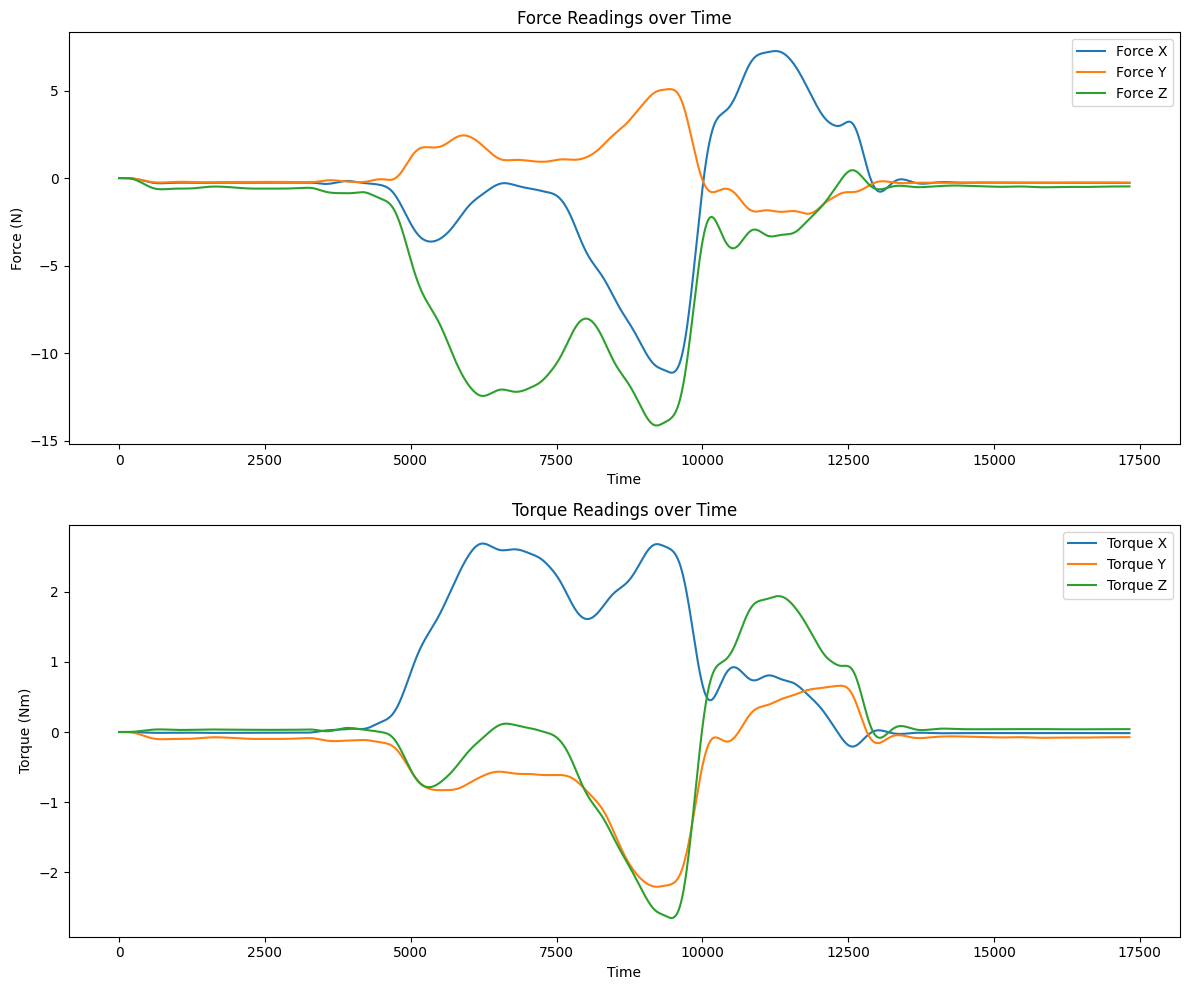

In [3]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Filter specifications
fs = 700  # Sampling frequency
cutoff = 1  # Cutoff frequency in Hz
order = 5  # Order of the filter

# Prepare the filter coefficients
b, a = butter_lowpass(cutoff, fs, order=order)

filtered_data = []
# Assume output_data_list is a list of dictionaries, each with keys like "translated_forces_x", etc.
for original_data in output_data_list:
    # Convert data to a numpy array
    sensor_data = np.array([
        original_data['translated_forces_x'],
        original_data['translated_forces_y'],
        original_data['translated_forces_z'],
        original_data['translated_torques_x'],
        original_data['translated_torques_y'],
        original_data['translated_torques_z']
    ]).T  # Transpose to make sure dimensions match expectation for lfilter

    # Apply the filter
    sensor_data_filtered = lfilter(b, a, sensor_data, axis=0)

    # Update the original data dictionary with filtered data
    original_data.update({
        "translated_forces_x": sensor_data_filtered[:, 0].tolist(),
        "translated_forces_y": sensor_data_filtered[:, 1].tolist(),
        "translated_forces_z": sensor_data_filtered[:, 2].tolist(),
        "translated_torques_x": sensor_data_filtered[:, 3].tolist(),
        "translated_torques_y": sensor_data_filtered[:, 4].tolist(),
        "translated_torques_z": sensor_data_filtered[:, 5].tolist()
    })

    filtered_data.append(original_data)

print(len(filtered_data))

plot_sensor_data_from_json(filtered_data[run])

In [4]:
import numpy as np

def detect_procedure_limits(sensor_data, threshold=0.01, look_back=10, look_forward=10):
    # Calculate the gradient of sensor data
    gradients = np.abs(np.gradient(sensor_data, axis=0))
    # Detect start
    start_indices = np.where((gradients > threshold).any(axis=1))[0]
    start_index = max(start_indices[0] - look_back, 0) if start_indices.size > 0 else 0
    # Detect end
    reversed_gradients = np.abs(np.gradient(sensor_data[::-1], axis=0))
    end_indices = np.where((reversed_gradients > threshold).any(axis=1))[0]
    end_index = len(sensor_data) - end_indices[0] + look_forward if end_indices.size > 0 else len(sensor_data)
    return start_index, end_index



def process_sensor_data(data_list):
    result_list = []
    for original_data in data_list:
        sensor_data = np.array([
            original_data['translated_forces_x'],
            original_data['translated_forces_y'],
            original_data['translated_forces_z'],
            original_data['translated_torques_x'],
            original_data['translated_torques_y'],
            original_data['translated_torques_z']
        ]).T  # Transpose to align with the dimensions expected by the analysis functions

        # Detect start and end indices for procedure
        start_index, end_index = detect_procedure_limits(sensor_data)

        # Cut the sensor data to these indices
        sensor_data_cut = sensor_data[start_index:end_index]

        # Update the original data dictionary with the new sliced data
        original_data.update({
            "translated_forces_x": sensor_data_cut[:, 0].tolist(),
            "translated_forces_y": sensor_data_cut[:, 1].tolist(),
            "translated_forces_z": sensor_data_cut[:, 2].tolist(),
            "translated_torques_x": sensor_data_cut[:, 3].tolist(),
            "translated_torques_y": sensor_data_cut[:, 4].tolist(),
            "translated_torques_z": sensor_data_cut[:, 5].tolist(),
            "procedure_start": start_index,
            "procedure_end": end_index
        })
        result_list.append(original_data)

    return result_list

cutted_data = process_sensor_data(filtered_data)
print(len(cutted_data))
# plot_sensor_data_from_json(cutted_data[0])

64


3
5
Number of data points: 12909
Recording duration: 17.675000190734863 seconds
Sampling frequency: 730.353598907842 Hz


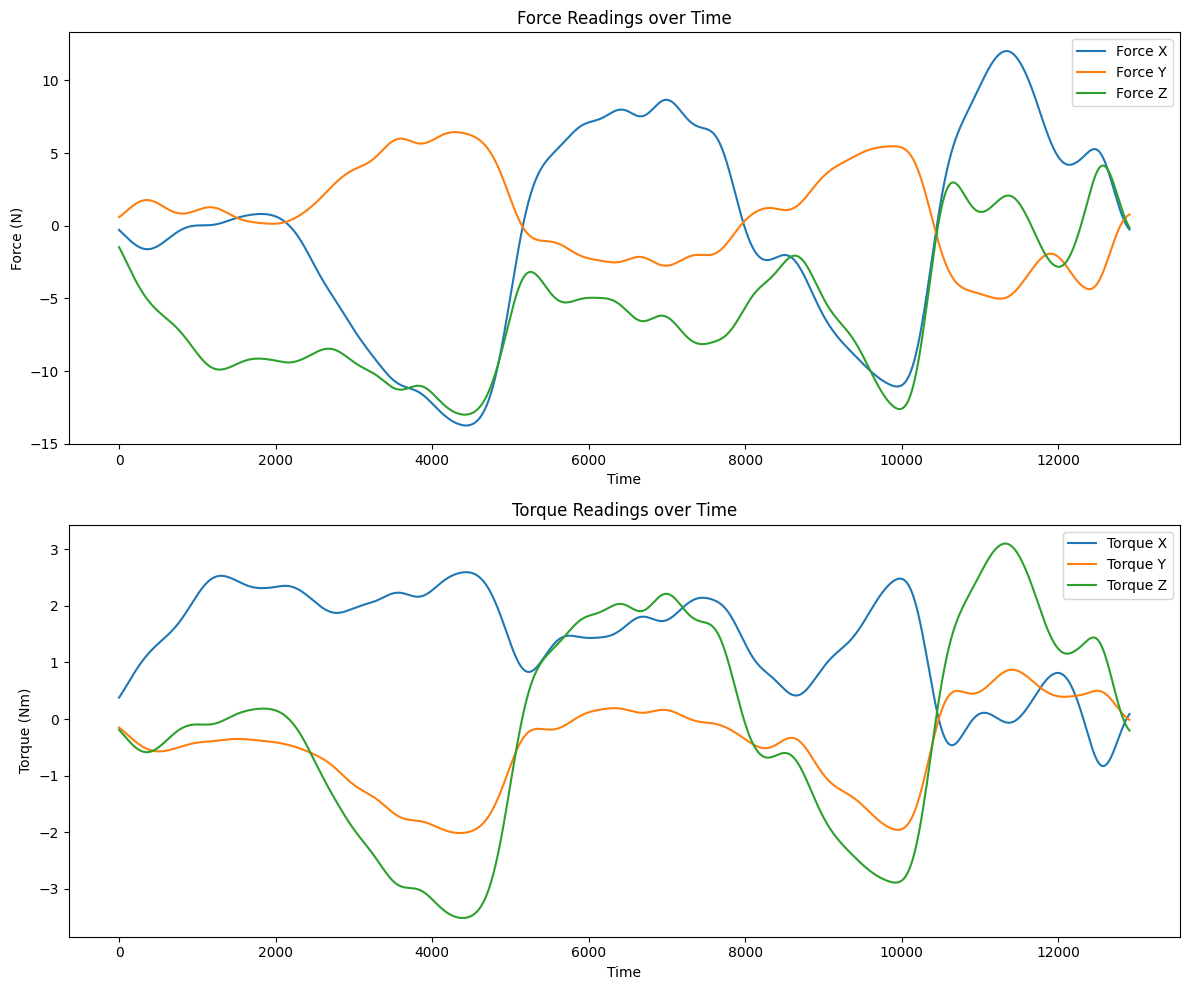

Number of data points: 12909
Recording duration: 17.675000190734863 seconds
Sampling frequency: 730.353598907842 Hz


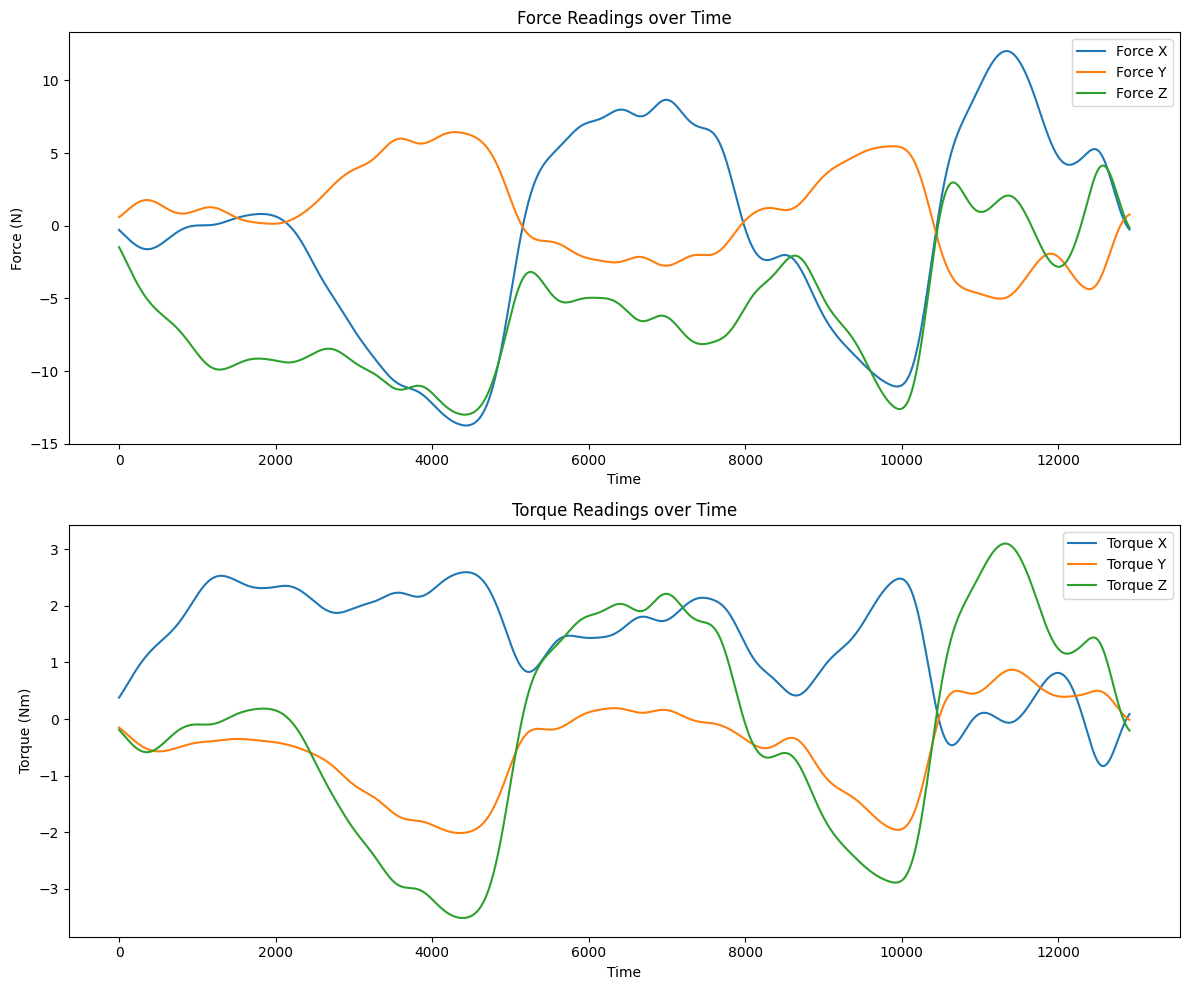

In [5]:
run = 3

print(filtered_data[run]["quadrant"])
print(filtered_data[run]["tooth"])


plot_sensor_data_from_json(filtered_data[run])
plot_sensor_data_from_json(cutted_data[run])

In [6]:
# now please tranlate the cutted data into a panda's object dictionary
import pandas as pd

def convert_to_pandas(data_list):
    result = {}
    for i, data in enumerate(data_list):
        df = pd.DataFrame(data)
        df['timestamp'] = range(len(df))
        result[i] = df
    return result

pandas_data = convert_to_pandas(cutted_data)


#please show the head of the data
pandas_data[run].head()

,quadrant,tooth,person_type,element_fractured,start_timestamp,end_timestamp,epoxy_failed,forceps_slipped,format_version,jaw_type,...,post_extraction_notes,translated_forces_x,translated_forces_y,translated_forces_z,translated_torques_x,translated_torques_y,translated_torques_z,procedure_start,procedure_end,timestamp
0,3,5,Student,False,1.719481e+09,1.719482e+09,False,False,2,Plastic,...,,-0.282279,0.587143,-1.478288,0.378126,-0.151538,-0.190781,3039,15948,0
1,3,5,Student,False,1.719481e+09,1.719482e+09,False,False,2,Plastic,...,,-0.287312,0.591066,-1.488057,0.380124,-0.152584,-0.192247,3039,15948,1
2,3,5,Student,False,1.719481e+09,1.719482e+09,False,False,2,Plastic,...,,-0.292355,0.595005,-1.497855,0.382129,-0.153634,-0.193716,3039,15948,2
3,3,5,Student,False,1.719481e+09,1.719482e+09,False,False,2,Plastic,...,,-0.297408,0.598961,-1.507679,0.384139,-0.154687,-0.195190,3039,15948,3
4,3,5,Student,False,1.719481e+09,1.719482e+09,False,False,2,Plastic,...,,-0.302470,0.602933,-1.517531,0.386155,-0.155743,-0.196667,3039,15948,4
